In [83]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input,LSTM, Embedding, Dense, Attention, Concatenate, TimeDistributed
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf

In [66]:
Data = pd.read_csv('Data/Wikihow_clean_50000', nrows = 10000)
Data = Data.dropna(axis = 0)
Data.head()

,Unnamed: 0,headline,title,text,clean_text,cleaned_headline
0,0,"\nKeep related supplies in the same area.,\nMa...",How to Be an Organized Artist1,"If you're a photographer, keep all the necess...",photographer keep necessary lens cords batteri...,_START_ keep related supplies in the same area...
1,1,\nCreate a sketch in the NeoPopRealist manner ...,How to Create a Neopoprealist Art Work,See the image for how this drawing develops s...,see image drawing develops step step however i...,_START_ create sketch in the neopoprealist man...
2,2,"\nGet a bachelor’s degree.,\nEnroll in a studi...",How to Be a Visual Effects Artist1,It is possible to become a VFX artist without...,possible become vfx artist without college deg...,_START_ get bachelor degree enroll in studio b...
3,3,\nStart with some experience or interest in ar...,How to Become an Art Investor,The best art investors do their research on t...,best art investors research pieces art buy som...,_START_ start with some experience or interest...
4,4,"\nKeep your reference materials, sketches, art...",How to Be an Organized Artist2,"As you start planning for a project or work, ...",start planning project work likely gathering s...,_START_ keep your reference materials sketches...


In [67]:
X_train, X_test, y_train, y_test = train_test_split(Data['clean_text'], Data['cleaned_headline'], test_size = .2, random_state = 4, shuffle = True) 

In [71]:
print(len(X_train), len(X_test))

7889 1973


In [68]:
# max_len values set the maximum length for both the text and summary
max_len_text = 400
max_len_summary = 80

In [72]:
# The tokenizer creates a 'token' for each word which is a number that corresponds with that word
X_tokenizer = Tokenizer()
X_tokenizer.fit_on_texts(list(X_train))

# Transforming the sequence of words into a corresponding sequence of their respective tokens
X_train = X_tokenizer.texts_to_sequences(X_train)
X_test = X_tokenizer.texts_to_sequences(X_test)

# Padding ensures that the sequences are all of the same size by adding empty tokens up to the max length 
X_train = pad_sequences(X_train,  maxlen=max_len_text, padding='post') 
X_test = pad_sequences(X_test, maxlen=max_len_text, padding='post')

x_voc_size = len(X_tokenizer.word_index) +1

In [73]:
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(y_train))


y_train = y_tokenizer.texts_to_sequences(y_train)
y_test = y_tokenizer.texts_to_sequences(y_test)

y_train = pad_sequences(y_train,  maxlen=max_len_summary, padding='post') 
y_test = pad_sequences(y_test, maxlen=max_len_summary, padding='post')

y_voc_size = len(y_tokenizer.word_index) +1

In [74]:
from keras import backend as K 

K.clear_session() 

# The latent dimension is the number of dimensions that each word embedding will correspond with
latent_dim = 500 


#Embedding layer
Encoder_inputs = Input(shape=(max_len_text,))

Encoder_embedding = Embedding(x_voc_size, latent_dim,trainable=True)(Encoder_inputs) 


lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm1') 

encoder_output1, h1, c1 = lstm1(Encoder_embedding) 


lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True, name = 'lstm2') 

encoder_output2, h2, c2 = lstm2(encoder_output1) 


lstm3 = LSTM(latent_dim, return_state=True, return_sequences=True, name = 'lstm3') 

encoder_outputs, h_state, c_state = lstm3(encoder_output2) 


# Decoder

decoder_inputs = Input(shape=(None,))

decoder_embedding = Embedding(y_voc_size, latent_dim,trainable=True)

dec_emb = decoder_embedding(decoder_inputs) 


#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True, name = 'decoder_lstm') 
decoder_lstm_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[h_state, c_state]) 


#Attention Layer
attention_output = Attention()([decoder_lstm_outputs, encoder_outputs]) 

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis= -1, name='concat_layer')([decoder_lstm_outputs, attention_output])

#Dense layer
decoder_dense = TimeDistributed(Dense(y_voc_size, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([Encoder_inputs, decoder_inputs], decoder_outputs) 

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 400, 500)     2611000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm1 (LSTM)                    [(None, 400, 500), ( 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

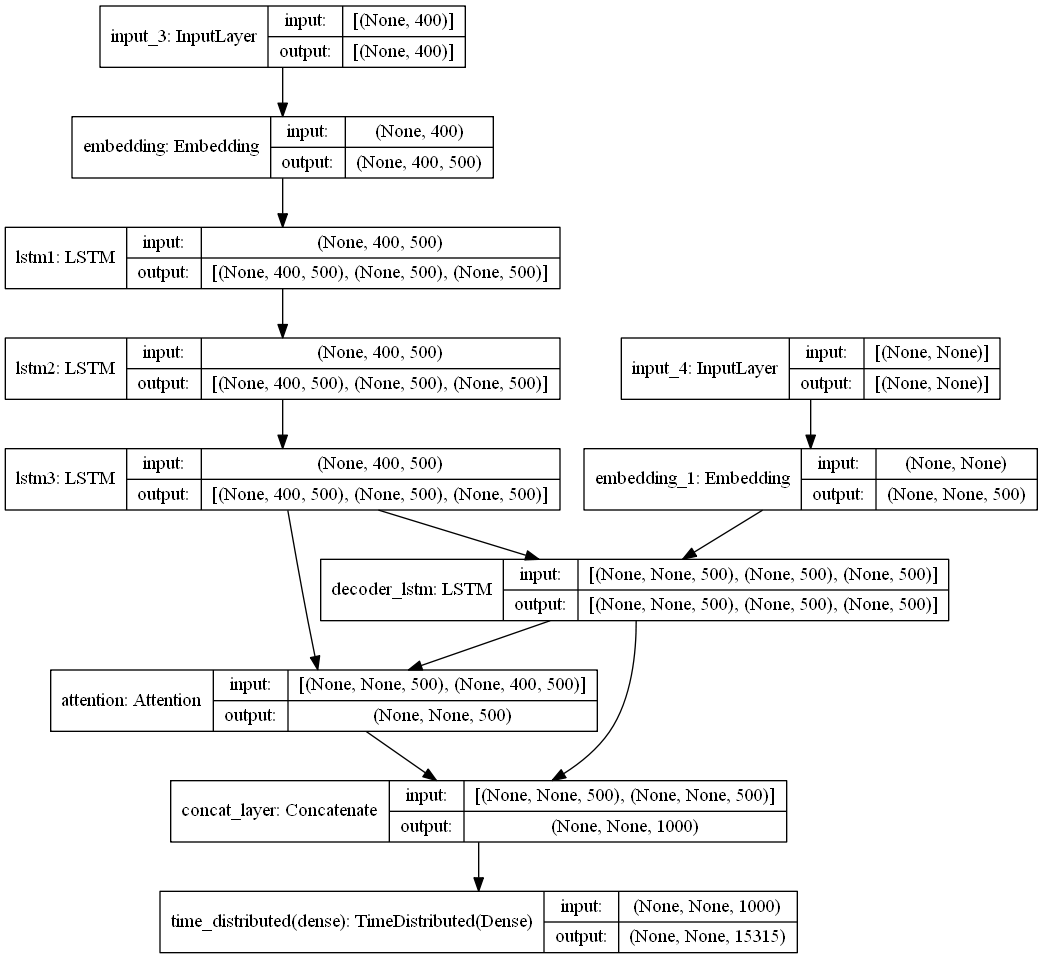

In [75]:
plot_model(model, show_shapes = True,expand_nested = True )

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

In [91]:
es = EarlyStopping(monitor='val_loss', mode='min', patience = 15, verbose=1)
cp_callback = ModelCheckpoint(filepath = 'model_train_1/cp.ckpt', save_weights_only= True, verbose  = 1)

In [14]:
# y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,:1].shape

# [X_test,y_test[:,-1:]], y_test.reshape(y_test.shape[0], y_test.shape[1], 1)


# y_train_reshaped = y_train.reshape(y_train.shape[0], max_len_summary)[:,1:]

# y_test_reshaped  =  y_test.reshape(y_test.shape[0] , max_len_summary)[:,1:]

 def Load_model(model, path, batches_per_epoch):
    model = load_model(path)
    initial_epoch = get_init_epoch(path)
    count = initial_epoch*batches_per_epoch
    return(initial_epoch, count)

In [ ]:
# Load_model(model, 'model_train_1', 79)

In [98]:
Xt, Xv, yt, yv = X_train[:100], X_test[:100], y_train[:100], y_test[:100]

In [ ]:
history = model.fit([Xt,yt], yt, epochs = 30, batch_size = 125, validation_data = ([Xv,yv], yv))

In [100]:
history = model.fit([X_train,y_train[:,:]], y_train, 
                    epochs = 10, batch_size = 125, 
                    validation_data = ([X_test,y_test[:,:]], y_test))

Epoch 1/10
64/64 [==============================] - 2503s 39s/step - loss: 2.1582 - val_loss: 1.6052
Epoch 2/10
64/64 [==============================] - 2910s 45s/step - loss: 1.2848 - val_loss: 0.9578
Epoch 3/10
64/64 [==============================] - 2952s 46s/step - loss: 0.8005 - val_loss: 0.6076
Epoch 4/10
64/64 [==============================] - 3008s 47s/step - loss: 0.5364 - val_loss: 0.4249
Epoch 5/10
64/64 [==============================] - 3116s 49s/step - loss: 0.3808 - val_loss: 0.3307
Epoch 6/10
64/64 [==============================] - 3199s 50s/step - loss: 0.2756 - val_loss: 0.2617
Epoch 7/10
64/64 [==============================] - 3227s 50s/step - loss: 0.2378 - val_loss: 0.2306
Epoch 8/10
64/64 [==============================] - 3161s 49s/step - loss: 0.1664 - val_loss: 0.1921
Epoch 9/10
64/64 [==============================] - 3193s 50s/step - loss: 0.1269 - val_loss: 0.1793
Epoch 10/10
64/64 [==============================] - 3230s 51s/step - loss: 0.0982 - val_lo

In [102]:
model.save('Models/lstm_model1h5', save_format = 'h5')

history = model.fit([X_train,y_train[:,:]], y_train, 
                    epochs = 30, batch_size = 125, 
                    validation_data = ([X_test,y_test[:,:]], y_test), 
                    callbacks = [es, cp_callback])

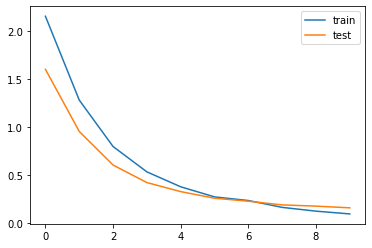

In [103]:
plt.plot(history.history['loss'], label ='train')
plt.plot(history.history['val_loss'], label = 'test')
plt.legend()
plt.show()

In [107]:
reverse_target_word = y_tokenizer.index_word
reverse_input_word = X_tokenizer.index_word
target_word_index = y_tokenizer.word_index

In [104]:
encoder_model = Model(inputs = Encoder_inputs, outputs = [encoder_outputs, h_state, c_state])

In [387]:
encoder_model.outputs

[<KerasTensor: shape=(None, 400, 500) dtype=float32 (created by layer 'lstm3')>,
 <KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm3')>,
 <KerasTensor: shape=(None, 500) dtype=float32 (created by layer 'lstm3')>]

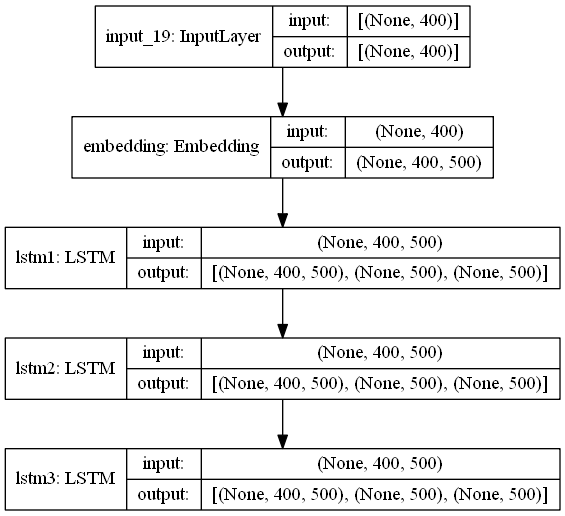

In [348]:
plot_model(encoder_model, show_shapes = True, to_file = 'encoder_model.png')

In [105]:
decoder_h_state_input = Input(shape=(latent_dim,))
decoder_c_state_input = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_len_text,latent_dim))

dec_emb2 = decoder_embedding(decoder_inputs)

decoder_outputs2 , h_state2, c_state2  = decoder_lstm(dec_emb2,initial_state=[decoder_h_state_input, decoder_c_state_input])

attention_output_inf = Attention()([decoder_outputs2, decoder_hidden_state_input]) 

decoder_concat_inf = Concatenate(axis= -1, name='concat')([decoder_outputs2, attention_output_inf])

decoder_outputs2 = decoder_dense(decoder_concat_inf)

decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input, decoder_h_state_input, decoder_c_state_input],
                     [decoder_outputs2] + [h_state2, c_state2])

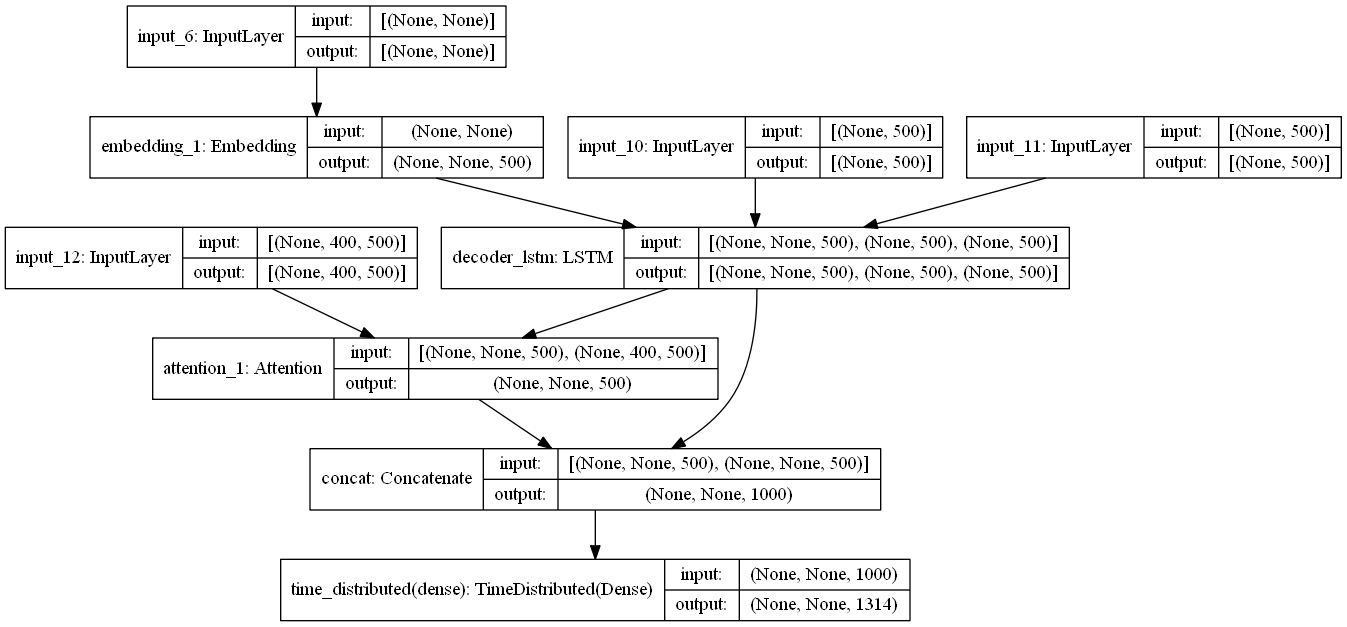

In [51]:
plot_model(decoder_model, show_shapes = True, to_file = 'decoder_model.png')

In [365]:
encoder_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 400)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 400, 500)          2611000   
_________________________________________________________________
lstm1 (LSTM)                 [(None, 400, 500), (None, 2002000   
_________________________________________________________________
lstm2 (LSTM)                 [(None, 400, 500), (None, 2002000   
_________________________________________________________________
lstm3 (LSTM)                 [(None, 400, 500), (None, 2002000   
Total params: 8,617,000
Trainable params: 8,617,000
Non-trainable params: 0
_________________________________________________________________


In [376]:
X_train_0t = tf.convert_to_tensor(X_train[0])

In [372]:
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state])
encode_c_state_r = np.array([encode_c_state])
encode_output_r =  encode_output.reshape(1,400,500)

print(encode_h_state_r.shape, encode_c_state_r.shape, encode_output_r.shape, target_seq.shape)

(1, 400, 500) (1, 400, 500) (1, 400, 500) (1, 1)


# Testing shapes Start

Data Cardinality Order
1. target_seq
2. encode_output
3. encode_h_state
4. encode_c_state

Input Order
'[Input2, Input1, Input2, Input3]'

In [144]:
Fake1 = np.array([np.zeros(154)])
Fake2 = np.array([np.zeros(254)])
Fake3 = np.array([np.zeros(354)])
Fake4 = np.array([np.zeros(454)])

In [117]:
fill1 = np.zeros((1,1))
fill2 = np.array([np.zeros((400,500))])
fill3 = np.array([np.zeros(500)])
# fill4

In [336]:
working_shapes = [fill1.shape, fill2.shape, fill3.shape, fill3.shape]
working_shapes

my_object_shapes = [target_seq.shape, encode_output_r.shape, encode_h_state_r.shape, encode_c_state_r.shape]
my_object_shapes

[(1, 1), (1, 400, 500), (1, 500), (1, 500)]

In [279]:
print(fill1.shape, fill2.shape, fill3.shape, fill3.shape)

(1, 1) (1, 400, 500) (1, 500) (1, 500)


In [405]:
encode_output.shape, np.array([encode_h_state[0]]).shape, np.array([encode_c_state[0]]).shape

((400, 1, 500), (1, 500), (1, 500))

# Testing Shapes End

In [410]:
# Trained on 100 rows 10 epochs
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state[-1]])
encode_c_state_r = np.array([encode_c_state[-1]])
encode_output_r =  encode_output.reshape(1,400,500)
    
    
target_seq = np.zeros((1,1))
    
target_seq[0,0] = target_word_index['start']
    
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([target_seq, encode_output_r, encode_h_state_r, encode_c_state_r])
        
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word[sampled_token_index]
       
    if(sampled_token!='end'):
        decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index
        
    encode_h_state, encode_c_state = h, c
        
print(decoded_sentence)

 wash existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and spring now breaks fun different boots surface stop stretchy opportunities result equals existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and spring now breaks fun different boots surface stop stretchy opportunities result equals existence broader filter light reinforce lather that qualities perk stinger environment eyes drain things stirrups bucket handle and


In [339]:
encode_output, encode_h_state, encode_c_state = encoder_model.predict(X_train[0])

encode_h_state_r = np.array([encode_h_state])
encode_c_state_r = np.array([[encode_c_state][0]])
encode_output_r =  encode_output.reshape(1,400,500)
    
    
target_seq = np.zeros((1,1))
    
target_seq[0,0] = target_word_index['start']
    
stop_condition = False
decoded_sentence = ''
while not stop_condition:
    output_tokens, h, c = decoder_model.predict([fill1, fill2, fill3, fill3])
        
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_token = reverse_target_word[sampled_token_index]
       
    if(sampled_token!='end'):
        decoded_sentence += ' ' + sampled_token
            
        if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
    target_seq = np.zeros((1,1))
    target_seq[0,0] = sampled_token_index
        
    encode_h_state, encode_c_state = h, c
        
print(decoded_sentence)

 investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors investors


In [415]:
def decode_sequence(input_seq):
      
    
    encode_output, encode_h_state, encode_c_state = encoder_model.predict(input_seq)

    encode_h_state_r = np.array([encode_h_state[-1]])
    encode_c_state_r = np.array([encode_c_state[-1]])
    encode_output_r =  encode_output.reshape(1,400,500)
    
    
    target_seq = np.zeros((1,1))
    
    target_seq[0,0] = target_word_index['start']
    
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [encode_output_r, encode_h_state_r, encode_c_state_r])
        
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word[sampled_token_index]
        
        if(sampled_token!='end'):
            decoded_sentence += ' ' + sampled_token
            
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary - 1)):
                stop_condition = True
                
        target_seq = np.zeros((1,1))
        target_seq[0,0] = sampled_token_index
        
        encode_h_state, encode_c_state = h, c
        
    return decoded_sentence

In [115]:
# 
decode_sequence(X_train[2])

' start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start start'